In [208]:
#pip install faiss-cpu

In [209]:
#pip install ultralytics streamlit opencv-python

In [210]:
from openai import OpenAI
from google.colab import userdata
import base64
from PIL import Image
import io
import faiss
import numpy as np
import google.generativeai as genai
import json
import os

In [211]:
client = OpenAI(
base_url="https://generativelanguage.googleapis.com/v1beta/openai",
api_key=userdata.get('GOOGLE_API_KEY')
)
genai.configure(api_key=userdata.get('GOOGLE_API_KEY'))


In [212]:
api_key = os.environ.get('GOOGLE_API_KEY')
print("done")

done


In [213]:
client = OpenAI(
    base_url="https://generativelanguage.googleapis.com/v1beta/openai",
    api_key=userdata.get('GOOGLE_API_KEY')
)

In [214]:
def encode_image_to_base64(image_path):
  with open(image_path, "rb") as img_file:
    return base64.b64encode(img_file.read()).decode("utf-8")

image_path = "/content/IMG-20250619-WA0008.jpg" # Path to your dog image
image_base64 = encode_image_to_base64(image_path)

In [215]:
import cv2
import os
import numpy as np
from ultralytics import YOLO

model = YOLO('yolov8l.pt')  # Ensure correct weights path

def detect_and_crop_single_dog(img):
    """
    Detects the first dog in the image, crops it, saves it.
    Returns cropped image (numpy array) or None if no dog detected.
    """
    results = model(img)

    for box, cls in zip(results[0].boxes.xyxy, results[0].boxes.cls):
        if int(cls) == 16:  # Class 16 = dog
            x1, y1, x2, y2 = map(int, box)
            cropped = img[y1:y2, x1:x2]

            os.makedirs('cropped_dogs', exist_ok=True)
            save_path = f'cropped_dogs/cropped_dog.jpg'
            cv2.imwrite(save_path, cropped)

            return cropped

    return None  # No dog detected


In [216]:
prompt = """
You are an expert in dog breed recognition and behavior analysis. Given the image of a dog, analyze it and provide the following details in a consistent, structured bullet-point format.

⚠ Format Requirements:
- Output should contain exactly 6 lines.
- No blank lines or extra spaces.
- Each line must start with the label followed by a colon and a single space, as shown below:
  Breed: Labrador Retriever
  Color & Markings: Golden with white chest
  Fur Type: Short
  Size: Medium
  Ear Type: Floppy
  Tail Type: Long

Labels to follow (use plain English, and write “Unknown” if a feature is not visible or determinable):
- Breed: (e.g., Labrador Retriever, German Shepherd, Mixed, Unknown)
- Color & Markings: (e.g., Golden with white chest, Black and tan, Spotted)
- Fur Type: (e.g., short, long, curly, wiry)
- Size: (small / medium / large)
- Ear Type: (e.g., floppy, erect, semi-erect)
- Tail Type: (e.g., long, curled, bushy, short)

Return only the above list using the exact same order and format with no explanations or commentary.
"""


0: 320x640 1 dog, 1671.4ms
Speed: 4.6ms preprocess, 1671.4ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)


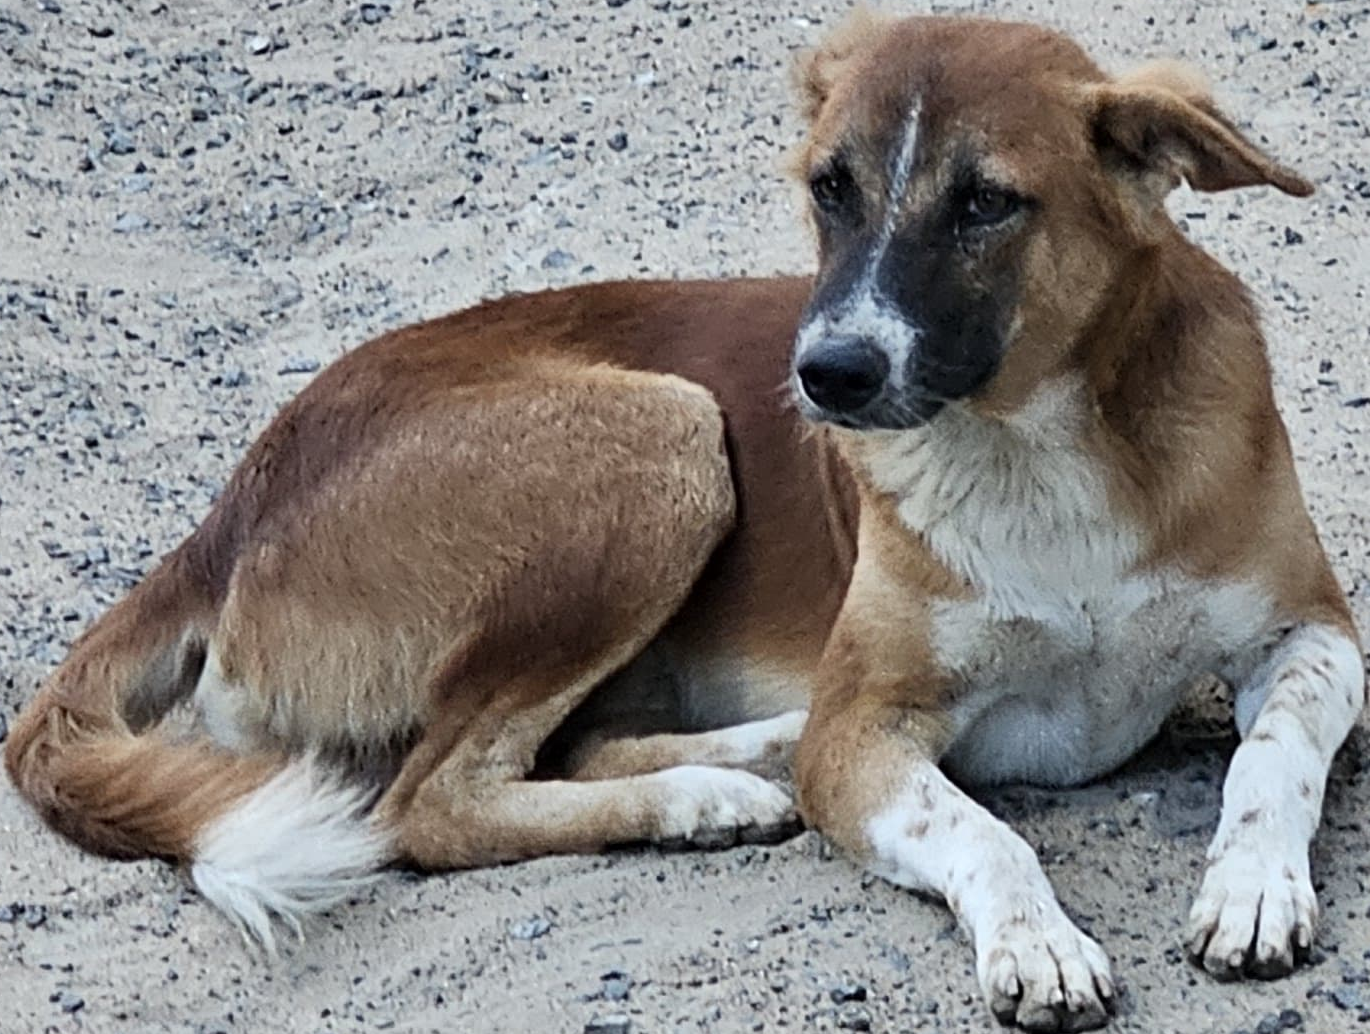

In [217]:
import cv2
import base64
import numpy as np
from google.colab.patches import cv2_imshow

# Load image from file
img = cv2.imread('/content/IMG-20250619-WA0044.jpg')

# Crop dog using your function
cropped_dog = detect_and_crop_single_dog(img)

if cropped_dog is None:
    print("No dog detected, cannot proceed.")
else:
    # ✅ Display the cropped image (Colab safe)
    cv2_imshow(cropped_dog)

    # ✅ Convert cropped image to Base64
    _, buffer = cv2.imencode('.jpg', cropped_dog)
    image_base64 = base64.b64encode(buffer).decode('utf-8')

In [218]:
response = client.chat.completions.create(
model="gemini-1.5-flash",
messages=[
{
  "role": "user",
  "content": [
    {"type": "text", "text": prompt},
    {
      "type": "image_url",
      "image_url": {
        "url": f"data:image/jpeg;base64,{image_base64}"
      }
    }
  ]
}
],
max_tokens=512,
temperature=0.7
)

In [219]:
print("Dog Identity Description:\n")
desc = response.choices[0].message.content
print(desc)

Dog Identity Description:

Breed: Mixed
Color & Markings: Brown with white markings
Fur Type: Short
Size: Medium
Ear Type: Semi-erect
Tail Type: Long



In [220]:
response = genai.embed_content(
model="models/embedding-001", # Gemini's text embedding model
content=desc.strip(),
task_type="retrieval_document" # You can also use "retrieval_query"
)
print(desc.strip())

Breed: Mixed
Color & Markings: Brown with white markings
Fur Type: Short
Size: Medium
Ear Type: Semi-erect
Tail Type: Long


In [221]:
embedding = np.array(response["embedding"], dtype="float32")
print(len(embedding))

768


In [222]:
INDEX_PATH = "dog_vectors.index"
METADATA_PATH = "dog_metadata.json"
dimension = len(embedding)
if os.path.exists(INDEX_PATH):
  index = faiss.read_index(INDEX_PATH)
  print("yes")
else:
  index = faiss.IndexFlatL2(dimension)
  print("no")

index.add(np.array([embedding]))  # ✅ first add embedding
faiss.write_index(index, INDEX_PATH)  # ✅ then save it to disk


yes


In [223]:
dimension = len(embedding)
import random
import string

def generate_dog_id(length=6):
  characters = string.ascii_uppercase + string.digits
  return ''.join(random.choices(characters, k=length))
dog_id = generate_dog_id()
index.add(np.array([embedding]))      # Add current embedding

In [224]:
if os.path.exists(METADATA_PATH):
  with open(METADATA_PATH, "r") as f:
    metadata_list = json.load(f)
    print("yes")
else:
  metadata_list = []

metadata_list.append({
"dog_id": dog_id,
"image_path": image_path,
"description": desc.strip()
})

yes


In [225]:
with open(METADATA_PATH, "w") as f:
  json.dump(metadata_list, f, indent=2)

print(f"✅ Successfully stored dog ID: {dog_id} with image: {image_path}")

✅ Successfully stored dog ID: Y1JLLJ with image: /content/IMG-20250619-WA0008.jpg


In [226]:
query_desc = """
Breed: Mixed
Color & Markings: Light Brown/Fawn
Fur Type: Short
Size: Medium
Ear Type: Semi-erect
Tail Type: Unknown
"""

In [227]:
query_embedding = genai.embed_content(
model="models/embedding-001",
content=query_desc.strip(),
task_type="retrieval_query"
)["embedding"]
query_embedding = np.array(query_embedding, dtype="float32").reshape(1, -1)

In [228]:
top_k = 5
distances, indices = index.search(query_embedding, top_k)

In [229]:
print(f"\n🔍 Top {top_k} Matches:")
for i, idx in enumerate(indices[0]):
  if idx >= len(metadata_list):
    continue # skip invalid index
  metadata = metadata_list[idx]
  similarity = 1 - (distances[0][i] / 2) # Convert L2 distance to similarity approximation
  similarity = round(similarity * 100, 2)
  print(f"\nResult {i+1}")
  print(f"✅ Dog ID: {metadata['dog_id']}")
  print(f"🖼️ Image Path: {metadata['image_path']}")
  print(f"📋 Description:\n{metadata['description']}")
  print(f"📊 Similarity: {similarity}%")

print(index.ntotal)


🔍 Top 5 Matches:

Result 1
✅ Dog ID: U9KNIS
🖼️ Image Path: /content/IMG-20250619-WA0008.jpg
📋 Description:
Breed: Mixed
Color & Markings: Light Brown
Fur Type: Short
Size: Medium
Ear Type: Semi-erect
Tail Type: Unknown
📊 Similarity: 81.08000183105469%

Result 2
✅ Dog ID: 6871CW
🖼️ Image Path: /content/IMG-20250619-WA0008.jpg
📋 Description:
Breed: Mixed
Color & Markings: Light brown with darker markings
Fur Type: Short
Size: Medium
Ear Type: Semi-erect
Tail Type: Long
📊 Similarity: 80.16000366210938%

Result 3
✅ Dog ID: Y1JLLJ
🖼️ Image Path: /content/IMG-20250619-WA0008.jpg
📋 Description:
Breed: Mixed
Color & Markings: Brown with white markings
Fur Type: Short
Size: Medium
Ear Type: Semi-erect
Tail Type: Long
📊 Similarity: 79.95999908447266%

Result 5
✅ Dog ID: RE1DYE
🖼️ Image Path: /content/IMG-20250619-WA0008.jpg
📋 Description:
Breed: Mixed
Color & Markings: Light tan
Fur Type: Short
Size: Medium
Ear Type: Semi-erect
Tail Type: Long
📊 Similarity: 79.56999969482422%
7


## **Approach 2**

In [230]:
print(index.ntotal)

7


In [231]:
for i, entry in enumerate(metadata_list):
  print(f"🆔 ID: {entry['dog_id']}")
  print(f"🖼️ Image: {entry['image_path']}")
  print(f"📄 Description:\n{entry['description']}")

🆔 ID: U9KNIS
🖼️ Image: /content/IMG-20250619-WA0008.jpg
📄 Description:
Breed: Mixed
Color & Markings: Light Brown
Fur Type: Short
Size: Medium
Ear Type: Semi-erect
Tail Type: Unknown
🆔 ID: L9O57F
🖼️ Image: /content/IMG-20250619-WA0008.jpg
📄 Description:
Breed: Mixed
Color & Markings: Black and white
Fur Type: Short
Size: Medium
Ear Type: Erect
Tail Type: Long
🆔 ID: 6871CW
🖼️ Image: /content/IMG-20250619-WA0008.jpg
📄 Description:
Breed: Mixed
Color & Markings: Light brown with darker markings
Fur Type: Short
Size: Medium
Ear Type: Semi-erect
Tail Type: Long
🆔 ID: QFNP19
🖼️ Image: /content/IMG-20250619-WA0008.jpg
📄 Description:
Breed: Unknown
Color & Markings: Light tan with dark gray patches
Fur Type: Short
Size: Medium
Ear Type: Semi-erect
Tail Type: Long
🆔 ID: RE1DYE
🖼️ Image: /content/IMG-20250619-WA0008.jpg
📄 Description:
Breed: Mixed
Color & Markings: Light tan
Fur Type: Short
Size: Medium
Ear Type: Semi-erect
Tail Type: Long
🆔 ID: Y1JLLJ
🖼️ Image: /content/IMG-20250619-WA0008.jpg
